# Huggingface Fine Tuning

## Overview

Step by step Hugginface fine tuning with DistilBert.

## Dependency

Using the data for [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data). Download **jigsaw-toxic-comment-classification-challenge.zip** and place it in the directory pointed by the **DATA_DIR** variable.

## Limitations

The [save_pretrained](https://huggingface.co/transformers/main_classes/model.html#transformers.PreTrainedModel.save_pretrained) method of the Huggingface Model class cannot be used on the fine-tuned model.

## References

* [A Visual Guide to Using BERT for the First Time](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)

* [Hugging Face Transformers: Fine-tuning DistilBERT for Binary Classification Tasks](https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379)

* [Training TFBertForSequenceClassification with custom X and Y data](https://stackoverflow.com/a/63295240/4281353)

---
# Setups

In [1]:
import os
import sys
import gc
import re
import string
import datetime
import logging
from pathlib import Path

## Constants

In [2]:
# To reduce the data volumen to run through the training in short timeframe.
TEST_MODE = False

## Execution recording (e.g. 2021JUL012322)
#TIMESTAMP = datetime.datetime.now().strftime("%Y%b%d%H%M").upper()
TIMESTAMP = input("Enter TIMESTAMP e.g. 2021JUL012322 to identify this execution.") 
print(f"Execution timestamp {TIMESTAMP}")

# Directory to manage the data. 
# Place jigsaw-toxic-comment-classification-challenge.zip in DATA_DIR
DATA_DIR = "."      # Directory where immutable files are located
BASE_DIR = "."      # Home directory of the project
OUTPUT_DIR = BASE_DIR + os.path.sep + "output"   # Directory to save mutable files.

# Flag to overwrite the cleaned data
FORCE_OVERWRITE = False

# Labbels that classifies the type of the comment.
CATEGORIES = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

Enter TIMESTAMP e.g. 2021JUL012322 to identify this execution.2021JUL05_1610
Execution timestamp 2021JUL05_1610


## Environment Specifics
### Google Colab

Google Colab specific operations.

In [3]:
def google_colab_info():
    """Information on the Google Colab environment
    """
    # --------------------------------------------------------------------------------
    # GPU
    # --------------------------------------------------------------------------------
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)

    # --------------------------------------------------------------------------------
    # Memory
    # --------------------------------------------------------------------------------
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

    if ram_gb < 20:
        print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
        print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
        print('re-execute this cell.')
    else:
        print('You are using a high-RAM runtime!')

In [4]:
try:
    # --------------------------------------------------------------------------------
    # Check if the environment is Google Colab.
    # --------------------------------------------------------------------------------
    import google.colab
    IN_GOOGLE_COLAB = True
    print("Using Google Colab environment.")

    # --------------------------------------------------------------------------------
    # Show Google Colab information
    # --------------------------------------------------------------------------------
    google_colab_info()

    # --------------------------------------------------------------------------------
    # Mount Google drive
    # --------------------------------------------------------------------------------
    google.colab.drive.mount('/content/drive', force_remount=True)
    
    # --------------------------------------------------------------------------------
    # Directory to manage the data
    # --------------------------------------------------------------------------------
    DATA_DIR = "/content/drive/MyDrive/home/data/kaggle/toxic_comment_classification"
    BASE_DIR = "/content/drive/MyDrive/home/repository/mon/huggingface/finetuning"
    OUTPUT_DIR = BASE_DIR + os.path.sep + "output"
    
except ModuleNotFoundError as e:
    # if str(e) == "No module named 'google.colab'":
    IN_GOOGLE_COLAB = False    
    print("Not using Google Colab environment.")

except ValueError as e:
    # https://stackoverflow.com/a/68203799/4281353
    print(f"{str(e)}: possible known issue https://stackoverflow.com/a/68203799/4281353")
    if os.path.isdir('/content/drive'):
        !ls -lrt /content/drive
        # !rm -rf /content/drive
        # google.colab.drive.flush_and_unmount()
    raise e
    

Using Google Colab environment.
Mon Jul  5 06:11:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                        

### Kaggle
* [How to detect the environment that I'm running the notebook](https://www.kaggle.com/getting-started/147177)

In [5]:
import os
print(f"os.environ.get('KAGGLE_KERNEL_RUN_TYPE','Localhost') == '{os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost')}'")

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE',''):
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')                         | We are running a Kaggle Notebook/Script - Could be Interactive or Batch Mode")  
    IN_KAGGLE = True

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive':
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive'        | We are running a Kaggle Notebook/Script - Interactive Mode")
    IN_KAGGLE = True

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Batch':
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Batch'              | We are running a Kaggle Notebook/Script - Batch Mode")
    IN_KAGGLE = True

if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == '':
    print("os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == ''                   | We are running code on Localhost")    
    IN_KAGGLE = False

if IN_KAGGLE:
    # --------------------------------------------------------------------------------
    # Directory to manage the data
    # --------------------------------------------------------------------------------
    DATA_DIR = "/kaggle/input/jigsaw-toxic-comment-classification-challenge"
    OUTPUT_DIR = "/kaggle/working"


os.environ.get('KAGGLE_KERNEL_RUN_TYPE','Localhost') == 'Localhost'
os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == ''                   | We are running code on Localhost


### Localhost

In [6]:
if (not IN_GOOGLE_COLAB) and (not IN_KAGGLE):
    !pip install -U h5py pandas matplotlib numpy 

## Modules

Install and load Python modules required for the task.

In [7]:
!pip install -U setuptools wheel
!pip install -U transformers
!pip install -U line_profiler memory_profiler

Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (57.1.0)
Requirement already up-to-date: wheel in /usr/local/lib/python3.7/dist-packages (0.36.2)
Requirement already up-to-date: transformers in /usr/local/lib/python3.7/dist-packages (4.8.2)
Requirement already up-to-date: line_profiler in /usr/local/lib/python3.7/dist-packages (3.3.0)
Requirement already up-to-date: memory_profiler in /usr/local/lib/python3.7/dist-packages (0.58.0)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Logging

Control the logging outputs to supress the warning and information to prevent the execution results from being cluttered. 

In [9]:
logging.disable(logging.WARNING)
logging.basicConfig(level=logging.ERROR)

## Utilities


## Jupyter Notebook

Jupyter cell format configurations. Align the cell output to the left.

In [10]:
%%html
<style>
table {float:left}
</style>

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=1000) 

## Pandas

In [11]:
import pandas as pd
pd.options.display.max_colwidth = 1000   # Allow long string content in a cell

## TensorFlow

Control TensorFlow logging.

| TF_CPP_MIN_LOG_LEVEL | Description|          
| - |------------- | 
|0| Suppress all messages are logged (default behavior)|
|1 |Suppress INFO messages are not printed|
|2 |Suppress INFO and WARNING messages are not printed|
|3 |Suppress INFO, WARNING, and ERROR messages are not printed|



In [12]:
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Transformers

[HuggingFace](https://huggingface.co/transformers/) offers the libarary for NLP (Natural Language Processing) based on the Transfoemer architecture introduced in the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) by Google.

> Transformers provides general-purpose architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between Jax, PyTorch and TensorFlow.

### Transfer Learning (Fine-Tuning)

Utilize the [Sequence Classification](https://huggingface.co/transformers/task_summary.html#sequence-classification) capabilty of BERT for the text classification by fine-tuing the pre-trained BERT model upon the data provided. 

* [Fine-tuning a pretrained model](https://huggingface.co/transformers/training.html)
> How to fine-tune a pretrained model from the Transformers library. In TensorFlow, models can be directly trained using Keras and the fit method. 

* [Fine-tuning with custom datasets](https://huggingface.co/transformers/custom_datasets.html)
> This tutorial will take you through several examples of using 🤗 Transformers models with your own datasets.

* [HuggingFace Text classification examples](https://github.com/huggingface/transformers/tree/master/examples/tensorflow/text-classification)
> This folder contains some scripts showing examples of text classification with the hugs Transformers library. 

The code in this notebook is based on the [run_text_classification.py](https://github.com/huggingface/transformers/blob/master/examples/tensorflow/text-classification/run_text_classification.py) example for TensorFlow and the code in the documentation [Fine-tuning with custom datasets](https://huggingface.co/transformers/custom_datasets.html).

In [13]:
import transformers
from transformers import (
    DistilBertTokenizerFast,
    TFDistilBertModel,
    # TFDistilBertForSequenceClassification,
)

# --------------------------------------------------------------------------------
# Control log level (https://huggingface.co/transformers/main_classes/logging.html)
# --------------------------------------------------------------------------------
os.environ['TRANSFORMERS_VERBOSITY'] = "error"
transformers.logging.set_verbosity(transformers.logging.ERROR)

## Output Directories

In [14]:
# Result output directory
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

RESULT_DIRECTORY = f"{OUTPUT_DIR}/run_{TIMESTAMP}"
Path(RESULT_DIRECTORY).mkdir(parents=True, exist_ok=True)

if not os.access(RESULT_DIRECTORY, os.W_OK):
    raise RuntimeError(f"{RESULT_DIRECTORY} not writable")

MODEL_DIRECTORY = "{parent}/model".format(
    parent=RESULT_DIRECTORY
)
Path(MODEL_DIRECTORY).mkdir(parents=True, exist_ok=True)
MODEL_FILE = MODEL_DIRECTORY + os.path.sep + "model.h5"

LOG_DIRECTORY = "{parent}/log".format(
    parent=RESULT_DIRECTORY,
)
Path(LOG_DIRECTORY).mkdir(parents=True, exist_ok=True)

---
# Data


### DATA_PATH
**DATA_PATH** variable points to the location of the data package for [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data) in the Google Drive or in the local directory. Unzip the data package to extract the data for training and testing.

* train.csv
* test.csv
* test_labels.csv - 0/1 binary labels to identify the comment is rated for each category (e.g. toxici).

In [15]:
if IN_GOOGLE_COLAB:
    DATA_PATH=f"{DATA_DIR}/jigsaw-toxic-comment-classification-challenge.zip"
elif IN_KAGGLE:
    pass
else:
    DATA_PATH = input("Enter the data archive path") 

In [16]:
if not IN_KAGGLE:
    !unzip -o $DATA_PATH -d $DATA_DIR || echo

!unzip -o $DATA_DIR/train.csv.zip -d .
!unzip -o $DATA_DIR/test.csv.zip -d .
!unzip -o $DATA_DIR/test_labels.csv.zip -d .

Archive:  /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/jigsaw-toxic-comment-classification-challenge.zip
  inflating: /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/sample_submission.csv.zip  
  inflating: /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/test.csv.zip  
  inflating: /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/test_labels.csv.zip  
  inflating: /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/train.csv.zip  
Archive:  /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/train.csv.zip
  inflating: ./train.csv             
Archive:  /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/test.csv.zip
  inflating: ./test.csv              
Archive:  /content/drive/MyDrive/home/data/kaggle/toxic_comment_classification/test_labels.csv.zip
  inflating: ./test_labels.csv       


## Raw Dataframes

Load the original data from the CSV files into ```raw_``` dataframes.

* raw_train is from train.csv
* raw_test is merged from test.csv and test_labels.csv

In [17]:
raw_train = pd.read_csv("./train.csv")
raw_test_data = pd.read_csv("./test.csv")
raw_test_label = pd.read_csv("./test_labels.csv")
raw_test = pd.merge(raw_test_data, raw_test_label, left_on='id', right_on='id', how='inner')

if TEST_MODE:
    raw_train = raw_train.head(64)
    raw_test = raw_test.head(32)

print(f"Counts train:{raw_train['id'].count()} test:{raw_test['id'].count()}")

Counts train:159571 test:153164


### Raw data (train.csv)

In [18]:
# If in Google colab runtime and got an error, restart the runtime.
# "AttributeError: 'NotebookFormatter' object has no attribute 'get_result'""
# https://stackoverflow.com/questions/66412776
raw_train.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0


In [19]:
raw_train[raw_train['toxic'] > 0].head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...",1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming back! Tosser.",1,0,0,0,0,0


### Raw data (test.csv)
Remove the rows where the label value is -1 as as the meaning is not clearly defined.

> test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring

In [20]:
raw_test[(raw_test['toxic'] >= 0)].head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very highly of you and would not revert without discussion.,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Religion? Really?? You mean, the way people have invariably kept adding """"Religion"""" to the Samuel Beckett infobox? And why do you bother bringing up the long-dead completely non-existent """"Influences"""" issue? You're just flailing, making up crap on the fly. \n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories! \n\n """,0,0,0,0,0,0


In [21]:
def balance(
    df, 
    data_col_name,
    label_col_name,
    retain_columns,
    max_replication_ratio=sys.maxsize
):
    """Balance the data volumes of positives and negatives
    The negatives (label==0) has more volume than the positives has, hence
    causing skewed data representation. To avoid the model from adapting to the
    majority (negative), naively balance the volumes so that they have same size.

    For the ratio = (negatives / positives), replicate positives 'ratio' times 
    to match the volume of negatives if ratio < max_replication_ratio.
    When ratio > max_replication_ratio, replicate max_replication_ratio times
    to the size = (positive_size * max_replication_ratio). Then take 'size'
    volume randomly from negatives.

    A portion of the negatives will not be used because of this balancing.

    Args:
        df: Pandas dataframe 
        data_col_name: Column name for the data
        label_col_name: Column name for the label
        retain_columns: Columns to retain in the dataframe to return
    Returns: 
        Pandas dataframe with the ratin_columns.
    """
    positive_indices = df.index[df[label_col_name]==1].tolist()
    negative_indices = df.index[df[label_col_name]==0].tolist()
    assert not bool(set(positive_indices) & set(negative_indices))

    positive_size = len(positive_indices)
    negative_size = len(negative_indices)
    ratio = np.minimum(negative_size // positive_size, max_replication_ratio)

    if ratio >= 2:
        # Generate equal size of indices for positives and negatives. 
        target_positive_indices = ratio * positive_indices
        target_negative_indices = np.random.choice(
            a=negative_indices, 
            size=ratio * positive_size,
            replace=False
        ).tolist()
        indices = target_positive_indices + target_negative_indices

        # Extract [data, label] with equal size of positives and negatives
        data = df.iloc[indices][
            df.columns[df.columns.isin(retain_columns)]
        ]

    else: 
        data = df[
            df.columns[df.columns.isin(retain_columns)]
        ]
    return data

# Keep the raw non-mutated whereas train/test are mutated.
train = balance(
    df=raw_train, 
    data_col_name='comment_text', 
    label_col_name='toxic',
    retain_columns=['id', 'comment_text', 'toxic']
)
test = raw_test[(raw_test['toxic'] >= 0)].copy()
if test['id'].count() >= train['id'].count():
    raise RuntimeError("Invalid counts. Verfity the train/test data.")

del raw_train, raw_test    
gc.collect()

145

---
# Model for Fine Tuning 



## Constants

In [22]:
# HuggingFace
MAX_SEQUENCE_LENGTH = 256   # Max token length to accept. 512 taks 1 hour/epoch on Google Colab

# Model training
NUM_LABELS = 2
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 1e-2
L2 = 1e-3
REDUCE_LR_PATIENCE = 1
EARLY_STOP_PATIENCE = 3

## Tokenizer

[Tokenizer](https://huggingface.co/transformers/main_classes/tokenizer.html) generates the instance of BatchEncoding which can be used as a Python dictionary. 

* [BatchEncoding](https://huggingface.co/transformers/main_classes/tokenizer.html#batchencoding)

> Holds the output of the encode_plus() and batch_encode() methods (tokens, attention_masks, etc).
> <br>
>This class is derived from a python dictionary and **can be used as a dictionary**. In addition, this class exposes utility methods to map from word/character space to token space.<br><br>
> Parameters<br>
> * data (dict) – Dictionary of lists/arrays/tensors returned by the encode/batch_encode methods (‘input_ids’, ‘attention_mask’, etc.).

The ```data``` attribute of the class is the tokens generated which has ```input_ides``` and ```attention_mask``` elements.

### input_ids

* [input_ids](https://huggingface.co/transformers/glossary.html#input-ids)

> The input ids are often the only required parameters to be passed to the model as input. They are **token indices, numerical representations of tokens** building the sequences that will be used as input by the model.

* [A Visual Guide to Using BERT for the First Time](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)

> 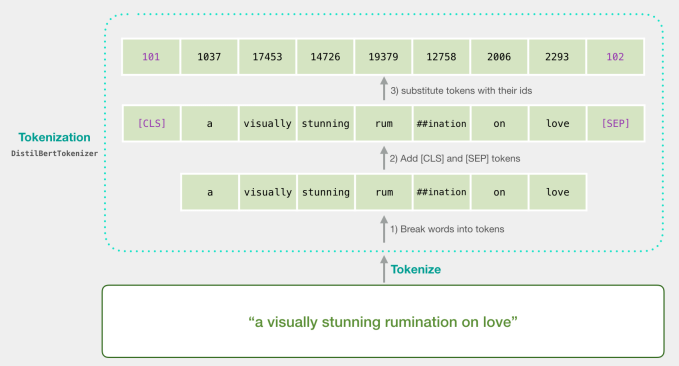


### attention_mask

* [Attention mask](https://huggingface.co/transformers/glossary.html#attention-mask)

> This argument indicates to the model which tokens should be attended to, and which should not.

If the attention_mask is ```0```, the token id is ignored. For instance if a sequence is padded to adjust the sequence length, the padded words should be ignored hence its attention_mask is 0.


In [23]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize(sentences, padding='max_length'):
    """Tokenize using the Huggingface tokenizer
    Args: 
        sentences: String or list of string to tokenize
        padding: Padding method ['do_not_pad'|'longest'|'max_length']
    """
    return tokenizer(
        sentences,
        truncation=True,
        padding=padding,
        max_length=MAX_SEQUENCE_LENGTH,
        return_tensors="tf"
    )

def decode(tokens):
    return tokenizer.decode(tokens)

When tokenized, ```i say hello``` (length 3) is padded with a special token ```[PAD]``` to match ```you say good bye``` (length 4). Hence the ```atttention_mask``` for ```i say hello``` has ```0``` at the end as in ```[1, 1, 1, 1, 1, 0]```.

In [24]:
sample_tokens = tokenize(
    [   # Two example seenteces
        "i say hello", 
        "you say good bye",
    ],
    padding='longest'
)
print(f"generatred {type(sample_tokens)} with content:\n{sample_tokens}")


generatred <class 'transformers.tokenization_utils_base.BatchEncoding'> with content:
{'input_ids': <tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 101, 1045, 2360, 7592,  102,    0],
       [ 101, 2017, 2360, 2204, 9061,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1]], dtype=int32)>}


In [25]:
for sequence in sample_tokens['input_ids']:
    print(decode(sequence))

[CLS] i say hello [SEP] [PAD]
[CLS] you say good bye [SEP]


### Special Tokens

[BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer) addes special tokens, hence enclose dwith ```[CLS]``` and ```[SEP]```. Espacially beware of the ```[CLS]``` that represents **Classification**. ```[SEP]``` token seprates each sequence. For Question Answer or Paraphrase tasks, ```[SEP]``` seprates the two sentences to compare.

* cls_token (str, optional, defaults to "**[CLS]**")<BR>The **Classifier Token which is used when doing sequence classification** (classification of the whole sequence instead of per-token classification). It is the first token of the sequence when built with special tokens.
* sep_token (str, optional, defaults to "[SEP]")<BR>The separator token, which is used when building a sequence from multiple sequences, e.g. two sequences for sequence classification or for a text and a question for question answering. It is also used as the last token of a sequence built with special tokens.
* unk_token (str, optional, defaults to "[UNK]")<BR>The unknown token. A token that is not in the vocabulary cannot be converted to an ID and is set to be this token instead.
* pad_token (str, optional, defaults to "[PAD]")<BR>The token used for padding, for example when batching sequences of different lengths.
* mask_token (str, optional, defaults to "[MASK]")<BR>The token used for masking values. This is the token used when training this model with masked language modeling. This is the token which the model will try to predict.

## Base Model - TFDistilBertModel

* [Hugging Face Transformers: Fine-tuning DistilBERT for Binary Classification Tasks](https://towardsdatascience.com/hugging-face-transformers-fine-tuning-distilbert-for-binary-classification-tasks-490f1d192379)

> TFDistilBertModel class to instantiate the base DistilBERT model **without any specific head on top** (as opposed to other classes such as TFDistilBertForSequenceClassification that do have an added classification head). <br><br>
We do not want any task-specific head attached because we simply want the pre-trained weights of the base model to provide a general understanding of the English language, and it will be our job to add our own classification head during the fine-tuning process in order to help the model distinguish between toxic comments.

* HuggingFace Document [TFDistilBertModel](https://huggingface.co/transformers/model_doc/distilbert.html#tfdistilbertmodel)

```
from transformers import DistilBertTokenizer, TFDistilBertModel
import tensorflow as tf

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
outputs = model(inputs)

last_hidden_states = outputs.last_hidden_state
```



In [26]:
MODEL_NAME = 'distilbert-base-uncased'
max_sequence_length = MAX_SEQUENCE_LENGTH
num_labels = NUM_LABELS

# Use TFDistilBertModel as TFDistilBertForSequenceClassification has classification heads added.
# base = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)
base = TFDistilBertModel.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

# Freeze the base model weights.
for layer in base.layers:
    layer.trainable = False
base.summary()

Model: "tf_distil_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
Total params: 66,362,880
Trainable params: 0
Non-trainable params: 66,362,880
_________________________________________________________________


In [27]:
# Cannot get the output_shape of the pretrained model with the error.
# AttributeError: The layer has never been called and thus has no defined output shape.
# https://stackoverflow.com/questions/68234881
#for layer in base.layers:
#    print(layer.output_shape)

## Output of TFDistilBertModel

```TFDistilBertModel``` generates an instance of ```TFBaseModelOutput``` whose ```last_hidden_state``` parameter is the output from the model last layer. The image in the cell downwards has the detail.

```
TFBaseModelOutput([(
    'last_hidden_state',
    <tf.Tensor: shape=(batch_size, sequence_lendgth, 768), dtype=float32, numpy=array([[[...]]], dtype=float32)>
)])
```
* [TFBaseModelOutput](https://huggingface.co/transformers/main_classes/output.html#tfbasemodeloutput)

> Parameters<br>
> * last_hidden_state (tf.Tensor of shape (batch_size, sequence_length, hidden_size)) – Sequence of hidden-states at the output of the last layer of the model.


In [28]:
base_model_output = base(sample_tokens)
#tf.print(base_model_output, summarize=1)
print(base_model_output)

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(2, 6, 768), dtype=float32, numpy=
array([[[-0.08046165, -0.0507057 ,  0.16511469, ...,  0.02624888,
          0.32072198,  0.29028502],
        [ 0.38065857,  0.14633183,  0.3267995 , ..., -0.03747691,
          0.6750764 ,  0.2675419 ],
        [-0.13755916,  0.23116165,  0.9399945 , ..., -0.4190009 ,
          0.03066512,  0.14690885],
        [-0.46870425, -0.15961106,  0.706487  , ...,  0.09092121,
          0.00915727, -0.02296945],
        [ 0.9486712 ,  0.28354228, -0.34940293, ...,  0.22489347,
         -0.41922653, -0.44231758],
        [ 0.11706695,  0.02730663,  0.36414492, ...,  0.22984342,
          0.05139092,  0.08807844]],

       [[-0.13671064, -0.07976629,  0.13336916, ..., -0.09188624,
          0.18120876,  0.14311405],
        [-0.18604988,  0.00228974,  0.8748206 , ...,  0.25758234,
          0.5174809 ,  0.07797474],
        [ 0.04087265,  0.11673994,  1.1603651 , ..., -0.40428668,
          0.04986678,  0.20

The numerical matrix of the output can be acquired with ```last_hidden_state``` property or the indexing ```[0]``` as the root class ModelOutput provides ```__getitems``` method for indexing.

* [ModelOutput](https://huggingface.co/transformers/main_classes/output.html#modeloutput) 
> Base class for all model outputs as dataclass. Has a __getitem__ that allows indexing by integer or slice (like a tuple) or strings (like a dictionary) that will ignore the None attributes. Otherwise behaves like a regular python dictionary.

In [29]:
print(base_model_output.last_hidden_state)

tf.Tensor(
[[[-0.08046165 -0.0507057   0.16511469 ...  0.02624888  0.32072198
    0.29028502]
  [ 0.38065857  0.14633183  0.3267995  ... -0.03747691  0.6750764
    0.2675419 ]
  [-0.13755916  0.23116165  0.9399945  ... -0.4190009   0.03066512
    0.14690885]
  [-0.46870425 -0.15961106  0.706487   ...  0.09092121  0.00915727
   -0.02296945]
  [ 0.9486712   0.28354228 -0.34940293 ...  0.22489347 -0.41922653
   -0.44231758]
  [ 0.11706695  0.02730663  0.36414492 ...  0.22984342  0.05139092
    0.08807844]]

 [[-0.13671064 -0.07976629  0.13336916 ... -0.09188624  0.18120876
    0.14311405]
  [-0.18604988  0.00228974  0.8748206  ...  0.25758234  0.5174809
    0.07797474]
  [ 0.04087265  0.11673994  1.1603651  ... -0.40428668  0.04986678
    0.20140114]
  [ 0.4905054   0.17764185  1.6637994  ... -0.26952428 -0.14997017
   -0.04277818]
  [ 0.90368366 -0.19236276  1.062132   ...  0.18384317 -0.45228904
    0.02702057]
  [ 0.9119451   0.19694906 -0.34033245 ...  0.13686879 -0.48537374
   -0.411

In [30]:
print(base_model_output[0])

tf.Tensor(
[[[-0.08046165 -0.0507057   0.16511469 ...  0.02624888  0.32072198
    0.29028502]
  [ 0.38065857  0.14633183  0.3267995  ... -0.03747691  0.6750764
    0.2675419 ]
  [-0.13755916  0.23116165  0.9399945  ... -0.4190009   0.03066512
    0.14690885]
  [-0.46870425 -0.15961106  0.706487   ...  0.09092121  0.00915727
   -0.02296945]
  [ 0.9486712   0.28354228 -0.34940293 ...  0.22489347 -0.41922653
   -0.44231758]
  [ 0.11706695  0.02730663  0.36414492 ...  0.22984342  0.05139092
    0.08807844]]

 [[-0.13671064 -0.07976629  0.13336916 ... -0.09188624  0.18120876
    0.14311405]
  [-0.18604988  0.00228974  0.8748206  ...  0.25758234  0.5174809
    0.07797474]
  [ 0.04087265  0.11673994  1.1603651  ... -0.40428668  0.04986678
    0.20140114]
  [ 0.4905054   0.17764185  1.6637994  ... -0.26952428 -0.14997017
   -0.04277818]
  [ 0.90368366 -0.19236276  1.062132   ...  0.18384317 -0.45228904
    0.02702057]
  [ 0.9119451   0.19694906 -0.34033245 ...  0.13686879 -0.48537374
   -0.411

### Shape
In the model ```distilbert-base-uncased```, each token is embedded into a vector of size **768**. 
```(batch_size, max_sequence_length, embedding_vector_size=768)```. According to the originan paper, the BERT/BASE model (as indicated in distilbert-***base***-uncased) has the embedding vector size 768 and the 12 layers to be compatible with OpenAI GPT for comparison.

* [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

> BERT/BASE (L=12, H=768, A=12, Total Parameters=110M) and BERT/LARGE (L=24, H=1024, A=16, Total Parameters=340M).



In [31]:
NUM_BASE_MODEL_OUTPUT = base_model_output.last_hidden_state.shape[-1]
print("Base model last layer ouptput shape:(batch_size, sequence_length, num_output)={}".format(
    base_model_output.last_hidden_state.shape
))
print(f"Number of output (number of neurons) in the base model last layer {NUM_BASE_MODEL_OUTPUT}")

Base model last layer ouptput shape:(batch_size, sequence_length, num_output)=(2, 6, 768)
Number of output (number of neurons) in the base model last layer 768



##Custom Model

The embedding vector for **```[CLS]```** in the model final layer output represents the classification that has been learned by the base model. Hence feed the embedding vector for **```[CLS]```** token into the classifiation head that you add on top of the base model. 

* [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

> The first token of every sequence is always ```a special classification token ([CLS])```. The final hidden state corresponding to this token is **used as the aggregate sequence representation for classification tasks**. Sentence pairs are packed together into a single sequence. We differentiate the sentences in two ways. First, we separate them with a special token ([SEP]). Second, we add a learned embedding to every token indicating whether it belongs to sentence A or sentence B.

Note that the BERT base model has not been pre-trained for sequence classification tasks as in the original paper.
> 
> 3.1 Pre-training BERT ...we pre-train BERT using two unsupervised tasks<br>
> * Task #1: Masked LM<br>
> * Task #2: Next Sentence Prediction (NSP)<br>

### Learning Rate

The original paper used 5e-5, 4e-5, 3e-5, and 2e-5 for fine-tuning                                                              .

> We use a batch size of 32 and fine-tune for 3 epochs over the data for all GLUE tasks. For each task, we selected the best fine-tuning learning rate (among 5e-5, 4e-5, 3e-5, and 2e-5) on the Dev set

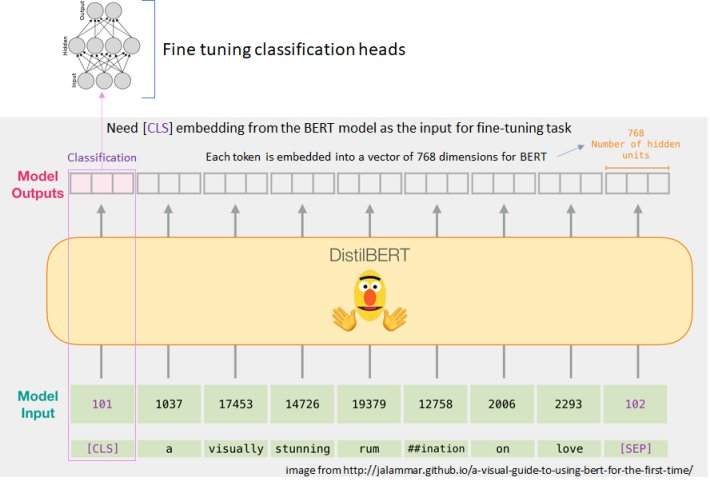


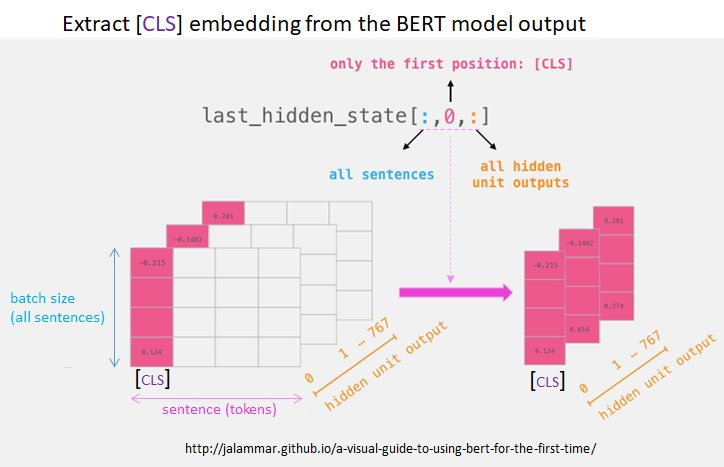


In [32]:
test_tokens = tokenize([
    "i am a cat who has no name.",
    "to be or not to be."
])
TEST_BATCH_SIZE = len(test_tokens)

### Input layers

The base model expects ```input_ids``` and ```attention_mask``` whose shape is ```(max_sequence_length,)```. Generate Keras Tensors for them with ```Input``` layer respectively and generate the output from the base model. The base model generates ```TFBaseModelOutput```. Feed the embedding of **```[CLS]```** to the next layer.

In [33]:
# Inputs for token indices and attention masks
input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input((max_sequence_length,), dtype=tf.int32, name='attention_mask')

# TFBaseModelOutput.last_hidden_state can be acquired with [0]
# [CLS] embedding is last_hidden_state[:, 0, :]
output = base([input_ids, attention_mask]).last_hidden_state[:, 0, :]

In [34]:
# model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output, name="base_cls")
# model.summary()
# Test the model input/output
# assert model(test_tokens).shape == (TEST_BATCH_SIZE, NUM_BASE_MODEL_OUTPUT)

### Classification layers

In [35]:
# -------------------------------------------------------------------------------
# Classifiation leayer 01
# --------------------------------------------------------------------------------
output = tf.keras.layers.Dropout(
    rate=0.15,
    name="01_dropout",
)(output)
 
output = tf.keras.layers.BatchNormalization(
    name="01_bn"
)(output)
output = tf.keras.layers.Dense(
    units=NUM_BASE_MODEL_OUTPUT,
    kernel_initializer='glorot_uniform',
    activation="relu",
    name="01_dense_relu_no_regularizer",
)(output)
 
# --------------------------------------------------------------------------------
# Classifiation leayer 02
# --------------------------------------------------------------------------------
output = tf.keras.layers.BatchNormalization(
    name="02_bn"
)(output)
output = tf.keras.layers.Dense(
    units=NUM_BASE_MODEL_OUTPUT,
    kernel_initializer='glorot_uniform',
    activation="relu",
    name="02_dense_relu_no_regularizer",
)(output)

### Softmax Layer


In [36]:
output = tf.keras.layers.Dense(
    units=NUM_LABELS,
    kernel_initializer='glorot_uniform',
    kernel_regularizer=tf.keras.regularizers.l2(l2=L2),
    activation='softmax',
    name="softmax"
)(output)

### Keras Model

In [37]:
name = f"{TIMESTAMP}_{MODEL_NAME.upper()}"
model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output, name=name)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)
assert model(test_tokens).shape == (TEST_BATCH_SIZE, NUM_LABELS)
model.summary()

Model: "2021JUL05_1610_DISTILBERT-BASE-UNCASED"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0       

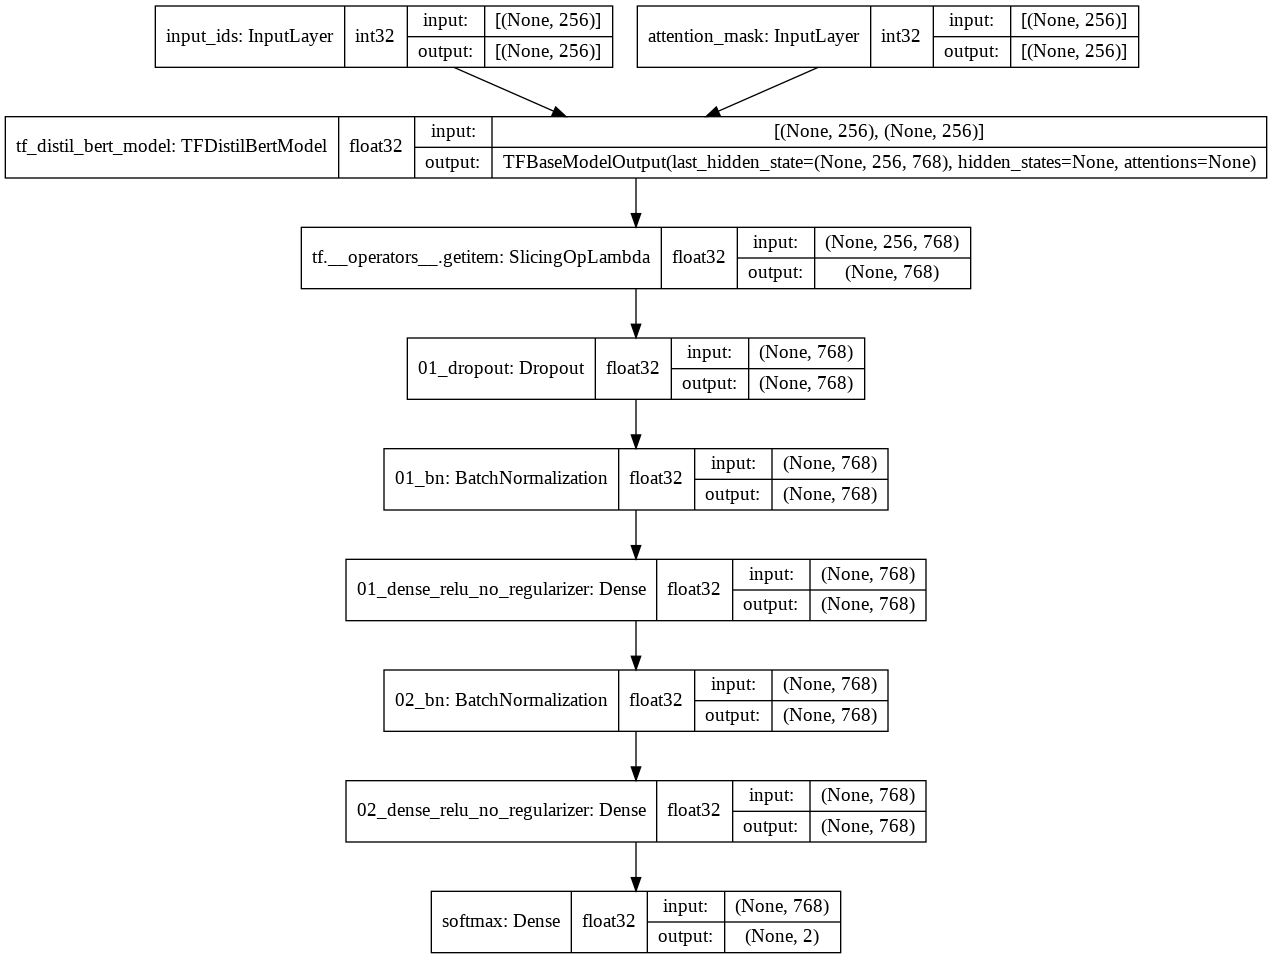

In [38]:
tf.keras.utils.plot_model(
    model, 
    show_shapes=True, 
    expand_nested=True, 
    show_dtype=True
)

---
# Training

### Keras Callbacks

Utilize [Keras Callbacks API](https://keras.io/api/callbacks/) to apply Eary Stopping, Reduce Learning Rate, and TensorBoard during the model training.



In [39]:
class SavePretrainedCallback(tf.keras.callbacks.Callback):
    """
    This is only for directly working on the Huggingface models.

    Hugging Face models have a save_pretrained() method that saves both 
    the weights and the necessary metadata to allow them to be loaded as 
    a pretrained model in future. This is a simple Keras callback that 
    saves the model with this method after each epoch.
    """
    def __init__(self, runner, output_dir, **kwargs):
        super().__init__()
        self.output_dir = output_dir

    def on_epoch_end(self, epoch, logs=None):
        # TODO: 
        #   save_pretrained() method is in the HuggingFace model only.
        #   Need to update for custom model saving.
        self.model.save_pretrained(self.output_dir)

class TensorBoardCallback(tf.keras.callbacks.TensorBoard):
    """TensorBoard visualization of the model training
    See https://keras.io/api/callbacks/tensorboard/
    """
    def __init__(self, output_directory):
        super().__init__(
            log_dir=output_directory,
            write_graph=True,
            write_images=True,
            histogram_freq=1,     # log histogram visualizations every 1 epoch
            embeddings_freq=1,    # log embedding visualizations every 1 epoch
            update_freq="epoch",  # every epoch
        )

class EarlyStoppingCallback(tf.keras.callbacks.EarlyStopping):
    """Stop training when no progress on the metric to monitor
    https://keras.io/api/callbacks/early_stopping/
    https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

    Using val_loss to monitor. 
    https://datascience.stackexchange.com/a/49594/68313
    Prefer the loss to the accuracy. Why? The loss quantify how certain 
    the model is about a prediction. The accuracy merely account for 
    the number of correct predictions. Similarly, any metrics using hard 
    predictions rather than probabilities have the same problem.
    """
    def __init__(self, patience=3):
        assert patience > 0
        super().__init__(
            monitor='val_loss', 
            mode='min', 
            verbose=1, 
            patience=patience,
            restore_best_weights=True
        )

class ModelCheckpointCallback(tf.keras.callbacks.ModelCheckpoint):
    """Check point to save the model
    See https://keras.io/api/callbacks/model_checkpoint/

    NOTE: 
        Did not work with the HuggingFace native model with the error.
        NotImplementedError: Saving the model to HDF5 format requires the model 
        to be a Functional model or a Sequential model. 
        It does not work for subclassed models, because such models are defined 
        via the body of a Python method, which isn't safely serializable.
        
        Did not work with the tf.keras.models.save_model nor model.save()
        as causing out-of-index errors or load_model() failures. Hence use
        save_weights_only=True.
    """
    def __init__(self, path_to_file):
        """
        Args:
            path_to_file: path to the model file to save at check points
        """
        super().__init__(
            filepath=path_to_file, 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True,
            save_weights_only=True,  # Cannot save entire model.
            save_freq="epoch",
            verbose=1
        )

class ReduceLRCallback(tf.keras.callbacks.ReduceLROnPlateau):
    """Reduce learning rate when a metric has stopped improving.
    See https://keras.io/api/callbacks/reduce_lr_on_plateau/
    """
    def __init__(self, patience=3):
        assert patience > 0
        super().__init__(
            monitor="val_loss",
            factor=0.3,
            patience=patience,
            verbose=1
        )

## Data Allocation


In [40]:
# --------------------------------------------------------------------------------
# Split data into training and validation
# --------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
train_data, validation_data, train_label, validation_label = train_test_split(
    train['comment_text'].tolist(),
    train['toxic'].tolist(),
    test_size=.2,
    shuffle=True
)

In [41]:
# Convert BatchEncoding to dictionary mapping to TF Tensor. 
# X = dict(tokenize(train_data))
# Y = tf.convert_to_tensor(train_label)
X = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(train_data)),  # Convert BatchEncoding instance to dictionary
    train_label
)).batch(BATCH_SIZE).prefetch(1)

In [42]:
V = tf.data.Dataset.from_tensor_slices((
    dict(tokenize(validation_data)),  # Convert BatchEncoding instance to dictionary
    validation_label
)).batch(BATCH_SIZE).prefetch(1)

## Run

In [43]:
print("""
MAX_SEQUENCE_LENGTH = {}
NUM_EPOCHS = {}
BATCH_SIZE = {}
LEARNING_RATE = {}
L2 = {}
REDUCE_LR_PATIENCE = {}
EARLY_STOP_PATIENCE = {}
MODEL_DIRECTORY = {}
LOG_DIRECTORY = {}
""".format(
    MAX_SEQUENCE_LENGTH,
    NUM_EPOCHS,
    BATCH_SIZE,
    LEARNING_RATE,
    L2,
    REDUCE_LR_PATIENCE,
    EARLY_STOP_PATIENCE,
    MODEL_DIRECTORY,
    LOG_DIRECTORY
))


MAX_SEQUENCE_LENGTH = 256
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.01
L2 = 0.001
REDUCE_LR_PATIENCE = 1
EARLY_STOP_PATIENCE = 3
MODEL_DIRECTORY = /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL05_1610/model
LOG_DIRECTORY = /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL05_1610/log



In [44]:
# Load the saved model if exists
if os.path.isfile(MODEL_FILE):
    print(f"loading the saved model parameters from {MODEL_FILE}")
    model.load_weights(MODEL_FILE)

In [ ]:
# --------------------------------------------------------------------------------
# Train the model
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
# Input data x can be a dict mapping input names to the corresponding array/tensors, 
# if the model has named inputs. Beware of the "names". y should be consistent with x 
# (you cannot have Numpy inputs and tensor targets, or inversely). 
# --------------------------------------------------------------------------------
history = model.fit(
    x=X,    # dictionary 
    # y=Y,
    y=None,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=V,
    callbacks=[
        EarlyStoppingCallback(patience=EARLY_STOP_PATIENCE),
        ReduceLRCallback(patience=REDUCE_LR_PATIENCE),
        ModelCheckpointCallback(MODEL_FILE),
        TensorBoardCallback(LOG_DIRECTORY)
    ]
)

Epoch 1/5
 892/6883 [==>...........................] - ETA: 17:15 - loss: 0.4879 - accuracy: 0.8576

## Save Model

Due to the issues, ```model.save_weights``` is the only way as of now. ModelCheckpoint requiring ```save_weights_only=False```.

save_format='h5' requires a file path but save_format='tf' requires a directory.


## Issues

* [tf.keras.models.save_model](https://www.tensorflow.org/api_docs/python/tf/keras/models/save_model)

Default save_traces=True causes IndexError: list index out of range
save_format='h5' causes NotYetImplementedException 

'''tf.keras.models.save_model(model, MODEL_DIRECTORY, save_format='tf', save_traces=False)''' causes the error below at ```tf.keras.models.load_model(MODEL_DIRECTORY)```.

```
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-71-01d66991d115> in <module>()
----> 1 tf.keras.models.load_model(MODEL_DIRECTORY)

11 frames
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/saving/saved_model/load.py in _unable_to_call_layer_due_to_serialization_issue(layer, *unused_args, **unused_kwargs)
    865       'recorded when the object is called, and used when saving. To manually '
    866       'specify the input shape/dtype, decorate the call function with '
--> 867       '`@tf.function(input_signature=...)`.'.format(layer.name, type(layer)))
    868 
    869 

ValueError: Cannot call custom layer tf_distil_bert_model of type <class 'tensorflow.python.keras.saving.saved_model.load.TFDistilBertModel'>, because the call function was not serialized to the SavedModel.Please try one of the following methods to fix this issue:

(1) Implement `get_config` and `from_config` in the layer/model class, and pass the object to the `custom_objects` argument when loading the model. For more details, see: https://www.tensorflow.org/guide/keras/save_and_serialize

(2) Ensure that the subclassed model or layer overwrites `call` and not `__call__`. The input shape and dtype will be automatically recorded when the object is called, and used when saving. To manually specify the input shape/dtype, decorate the call function with `@tf.function(input_signature=...)`.
```

In [ ]:
model.save_weights(
    MODEL_FILE, overwrite=True, save_format='h5'
)
# model.load_weights(filepath)

---
# Evaluation

In [ ]:
tokens = dict(tokenize(test['comment_text'].tolist()))
test_dataset = tf.data.Dataset.from_tensor_slices((
    tokens,
    test['toxic']
))
evaluation = model.evaluate(
    test_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(1)
)
evaluation

## Recall

In [ ]:
predictions = np.argmax(model.predict(tokens), axis=-1)
test['prediction'] = predictions

In [ ]:
PP = test[(test['prediction'] > 0.5)]['id'].count()
NP = test[(test['prediction'] <= 0.5)]['id'].count()
ALL = PP + NP

# TP: True Positive Prediction
# AP: Actual Positive
# TN: True Negative Prediction
# AN: Actual Negative
TP = test[(test['toxic'] == 1) & (test['prediction'] > 0.5)]['id'].count()
AP = test[(test['toxic'] == 1)]['id'].count()
TN = test[(test['toxic'] == 0) & (test['prediction'] <= 0.3)]['id'].count()
AN = test[(test['toxic'] == 0)]['id'].count()

print(f"TP {TP/ALL:0.3f} FP {(PP-TP)/ALL:0.3f} TN: {TN/ALL:0.3f} FN {(NP-TN)/ALL:0.3f}" ) 
if AP > 0:
    print(f"Positive/toxic     : Recall {TP/AP:0.3f}" ) 
if AN > 0:
    print(f"Negative/non-toxic : Recall {TN/AN:0.3f}") 

---
# Results

## 2021JUL05_1040

Dense(n, 'relu')-> Dense(n/2, 'linear')-> BN()-> Dense(n, 'linear') -> Dense(2,softmax) 

* Regularizer in Dense is not consistent

### Parameters
```
MAX_SEQUENCE_LENGTH = 256
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.01
REDUCE_LR_PATIENCE = 1
EARLY_STOP_PATIENCE = 3
MODEL_DIRECTORY = /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL05_1040/model
LOG_DIRECTORY = /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL05_1040/log
```

### Model

```
Model: "2021JUL05_1040_DISTILBERT-BASE-UNCASED"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 768)          0           tf_distil_bert_model[1][0]       
__________________________________________________________________________________________________
01_dropout_01 (Dropout)         (None, 768)          0           tf.__operators__.getitem_1[0][0] 
__________________________________________________________________________________________________
01_dense_relu (Dense)           (None, 768)          590592      01_dropout_01[0][0]              
__________________________________________________________________________________________________
02_dense_linear_01 (Dense)      (None, 384)          295296      01_dense_relu[0][0]              
__________________________________________________________________________________________________
02_bn (BatchNormalization)      (None, 384)          1536        02_dense_linear_01[0][0]         
__________________________________________________________________________________________________
02_dense_linear_02 (Dense)      (None, 768)          295680      02_bn[0][0]                      
__________________________________________________________________________________________________
softmax (Dense)                 (None, 2)            1538        02_dense_linear_02[0][0]         
==================================================================================================
Total params: 67,547,522
Trainable params: 1,183,874
Non-trainable params: 66,363,648
```

Classification heads.
```
# --------------------------------------------------------------------------------
# Dense(n, 'relu')->Dense(n/2, 'linear')->BN()->Dense(n, 'linear') 
# --------------------------------------------------------------------------------
# By Reza: [Dense(n/2, 'linear')->BN()->Dense(n, 'linear')] is the same as 
# covariance matrix decomposition which Relu would interfere with that. 
# It essentially estimates eigenvectors of the distribution of your items but 
# selects the top n/2 eigenvectors for which the eigenvalues are the largest 
# (the best separators). BN would play the role of removing the mean of the 
# population (covariance is calculated on the centered data). 
# 
# In general, you use Dense(?, linear)->BN->transfer function. 
# The reason is that BN is supposed to redistribute your data around the center, 
# and kind of in a normal distribution way with mean zero and variance 1. 
# Now, if you apply a dense and that moves things away from the center and then 
# apply transfer function then you may end-up with an ill-posed distribution of 
# your items, on which application of BN would not be effective. For example, 
# assume your dense moves things to a far point from the center and you apply 
# tanh as transfer. That would end up with all items mapped into all 1's for 
# all dimensions. BN would map this to the center of the coordinate system with 
# variance 0 (all items would be the same). This is ill-posed.
# --------------------------------------------------------------------------------
output = tf.keras.layers.Dropout(
    rate=0.15,
    name="01_dropout_01",
)(output)

output = tf.keras.layers.Dense(
    units=NUM_BASE_MODEL_OUTPUT,
    kernel_initializer='glorot_uniform',
    activation="relu",
    name="01_dense_relu",
)(output)

# --------------------------------------------------------------------------------
# covariance matrix decomposition
# --------------------------------------------------------------------------------
output = tf.keras.layers.Dense(
    units=NUM_BASE_MODEL_OUTPUT // 2,
    kernel_initializer='glorot_uniform',
    kernel_regularizer=tf.keras.regularizers.l2(l2=L2),
    activation="linear",
    name="02_dense_linear_01",
)(output)
output = tf.keras.layers.BatchNormalization(
    name="02_bn"
)(output)
output = tf.keras.layers.Dense(
    units=NUM_BASE_MODEL_OUTPUT,
    kernel_initializer='glorot_uniform',
    kernel_regularizer=tf.keras.regularizers.l2(l2=L2),
    activation="linear",
    name="02_dense_linear_02",
)(output)
```

### History

```
Epoch 1/5
6883/6883 [==============================] - 875s 126ms/step - loss: 0.5284 - accuracy: 0.8705 - val_loss: 0.2603 - val_accuracy: 0.8971

Epoch 00001: val_loss improved from inf to 0.26034, saving model to /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL05_1040/model/model.h5
Epoch 2/5
6883/6883 [==============================] - 866s 126ms/step - loss: 0.3563 - accuracy: 0.8795 - val_loss: 0.2515 - val_accuracy: 0.8965

Epoch 00002: val_loss improved from 0.26034 to 0.25148, saving model to /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL05_1040/model/model.h5
Epoch 3/5
6883/6883 [==============================] - 865s 126ms/step - loss: 0.4304 - accuracy: 0.8819 - val_loss: 0.3062 - val_accuracy: 0.8712

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.

Epoch 00003: val_loss did not improve from 0.25148
Epoch 4/5
6883/6883 [==============================] - 865s 126ms/step - loss: 0.2710 - accuracy: 0.8893 - val_loss: 0.2554 - val_accuracy: 0.8951

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009000000078231095.

Epoch 00004: val_loss did not improve from 0.25148
Epoch 5/5
6883/6883 [==============================] - 866s 126ms/step - loss: 0.2651 - accuracy: 0.8909 - val_loss: 0.2239 - val_accuracy: 0.9084

Epoch 00005: val_loss improved from 0.25148 to 0.22394, saving model to /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL05_1040/model/model.h5
```

### Evaluation
```
2000/2000 [==============================] - 189s 93ms/step - loss: 0.3851 - accuracy: 0.8450
[0.38509151339530945, 0.8449935913085938]
```

### Recall

```
TP 0.083 FP 0.143 TN: 0.762 FN 0.012
Positive/toxic     : Recall 0.875
Negative/non-toxic : Recall 0.842
```


# TBD

Dense(n, 'relu')-> Dense(n/2, 'linear')-> BN()-> Dense(n, 'linear') -> Dense(2,softmax)

Weight regularizer in Dense only when NOT preceeded by BN.

### Parameters
```
```

### Model
```
```

Classification heads

```
# --------------------------------------------------------------------------------
# Dense(n, 'relu')->Dense(n/2, 'linear')->BN()->Dense(n, 'linear') 
# --------------------------------------------------------------------------------
# By Reza: [Dense(n/2, 'linear')->BN()->Dense(n, 'linear')] is the same as 
# covariance matrix decomposition which Relu would interfere with that. 
# It essentially estimates eigenvectors of the distribution of your items but 
# selects the top n/2 eigenvectors for which the eigenvalues are the largest 
# (the best separators). BN would play the role of removing the mean of the 
# population (covariance is calculated on the centered data). 
# 
# In general, you use Dense(?, linear)->BN->transfer function. 
# The reason is that BN is supposed to redistribute your data around the center, 
# and kind of in a normal distribution way with mean zero and variance 1. 
# Now, if you apply a dense and that moves things away from the center and then 
# apply transfer function then you may end-up with an ill-posed distribution of 
# your items, on which application of BN would not be effective. For example, 
# assume your dense moves things to a far point from the center and you apply 
# tanh as transfer. That would end up with all items mapped into all 1's for 
# all dimensions. BN would map this to the center of the coordinate system with 
# variance 0 (all items would be the same). This is ill-posed.
# --------------------------------------------------------------------------------
output = tf.keras.layers.Dropout(
    rate=0.15,
    name="01_dropout_01",
)(output)
 
output = tf.keras.layers.Dense(
    units=NUM_BASE_MODEL_OUTPUT,
    kernel_initializer='glorot_uniform',
    kernel_regularizer=tf.keras.regularizers.l2(l2=L2),
    activation="relu",
    name="01_dense_relu",
)(output)
 
# --------------------------------------------------------------------------------
# covariance matrix decomposition
# --------------------------------------------------------------------------------
output = tf.keras.layers.Dense(
    units=NUM_BASE_MODEL_OUTPUT // 2,
    kernel_initializer='glorot_uniform',
    activation="linear",
    name="02_dense_linear_01",
)(output)
output = tf.keras.layers.BatchNormalization(
    name="02_bn"
)(output)
output = tf.keras.layers.Dense(
    units=NUM_BASE_MODEL_OUTPUT,
    kernel_initializer='glorot_uniform',
    activation="linear",
    name="02_dense_linear_02",
)(output)
```

### History

```
```

### Evaluation
```
```

### Recall

```
```


# 2021JUL05_1300

Dense(n, 'relu')-> BN()-> Dense(n/2, 'relu') -> BN()-> Dense(2,softmax) 

* Regularizer in Dense is not consistent

### Parameters
```
MAX_SEQUENCE_LENGTH = 256
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.01
REDUCE_LR_PATIENCE = 1
EARLY_STOP_PATIENCE = 3
MODEL_DIRECTORY = /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL05_1300/model
LOG_DIRECTORY = /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL05_1300/log
```

### Model
```
Model: "2021JUL05_1300_DISTILBERT-BASE-UNCASED"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_distil_bert_model[0][0]       
__________________________________________________________________________________________________
01_dropout (Dropout)            (None, 768)          0           tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________________
01_bn (BatchNormalization)      (None, 768)          3072        01_dropout[0][0]                 
__________________________________________________________________________________________________
01_dense_relu (Dense)           (None, 768)          590592      01_bn[0][0]                      
__________________________________________________________________________________________________
02_bn (BatchNormalization)      (None, 768)          3072        01_dense_relu[0][0]              
__________________________________________________________________________________________________
02_dense_relu (Dense)           (None, 384)          295296      02_bn[0][0]                      
__________________________________________________________________________________________________
softmax (Dense)                 (None, 2)            770         02_dense_relu[0][0]              
==================================================================================================
Total params: 67,255,682
Trainable params: 889,730
Non-trainable params: 66,365,952
```

Classification heads

```
#-------------------------------------------------------------------------------
# Classifiation leayer 01
# --------------------------------------------------------------------------------
output = tf.keras.layers.Dropout(
    rate=0.15,
    name="01_dropout",
)(output)
 
output = tf.keras.layers.BatchNormalization(
    name="01_bn"
)(output)
output = tf.keras.layers.Dense(
    units=NUM_BASE_MODEL_OUTPUT,
    kernel_initializer='glorot_uniform',
    activation="relu",
    name="01_dense_relu",
)(output)
 
# --------------------------------------------------------------------------------
# Classifiation leayer 02
# --------------------------------------------------------------------------------
output = tf.keras.layers.BatchNormalization(
    name="02_bn"
)(output)
output = tf.keras.layers.Dense(
    units=NUM_BASE_MODEL_OUTPUT // 2,
    kernel_initializer='glorot_uniform',
    kernel_regularizer=tf.keras.regularizers.l2(l2=L2),
    activation="relu",
    name="02_dense_relu",
)(output)
```

### History

```
Epoch 1/5
6883/6883 [==============================] - 875s 126ms/step - loss: 0.3234 - accuracy: 0.8764 - val_loss: 0.2382 - val_accuracy: 0.9035

Epoch 00001: val_loss improved from inf to 0.23823, saving model to /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL05_1300/model/model.h5
Epoch 2/5
6883/6883 [==============================] - 867s 126ms/step - loss: 0.2801 - accuracy: 0.8857 - val_loss: 0.2252 - val_accuracy: 0.9076

Epoch 00002: val_loss improved from 0.23823 to 0.22524, saving model to /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL05_1300/model/model.h5
Epoch 3/5
6883/6883 [==============================] - 866s 126ms/step - loss: 0.2721 - accuracy: 0.8889 - val_loss: 0.2207 - val_accuracy: 0.9122

Epoch 00003: val_loss improved from 0.22524 to 0.22073, saving model to /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL05_1300/model/model.h5
Epoch 4/5
6883/6883 [==============================] - 867s 126ms/step - loss: 0.2672 - accuracy: 0.8912 - val_loss: 0.2216 - val_accuracy: 0.9125

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.

Epoch 00004: val_loss did not improve from 0.22073
Epoch 5/5
6883/6883 [==============================] - 865s 126ms/step - loss: 0.2469 - accuracy: 0.8971 - val_loss: 0.2027 - val_accuracy: 0.9197

Epoch 00005: val_loss improved from 0.22073 to 0.20270, saving model to /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL05_1300/model/model.h5
```

### Evaluation
```
2000/2000 [==============================] - 190s 94ms/step - loss: 0.3735 - accuracy: 0.8491
[0.37352147698402405, 0.8491044044494629]
```

### Recall

```
TP 0.083 FP 0.139 TN: 0.766 FN 0.012
Positive/toxic     : Recall 0.872
Negative/non-toxic : Recall 0.847
```


# 2021JUL051426

Dense(n, 'relu')-> BN()-> Dense(n/2, 'relu') -> BN()-> Dense(2,softmax)

Save in 2021JUL05_1300. Run by mistake.

### Parameters
```
MAX_SEQUENCE_LENGTH = 256
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.01
REDUCE_LR_PATIENCE = 1
EARLY_STOP_PATIENCE = 3
MODEL_DIRECTORY = /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL051426/model
LOG_DIRECTORY = /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL051426/log
```

### Model
```
Model: "2021JUL051426_DISTILBERT-BASE-UNCASED"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_distil_bert_model[0][0]       
__________________________________________________________________________________________________
01_dropout (Dropout)            (None, 768)          0           tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________________
01_bn (BatchNormalization)      (None, 768)          3072        01_dropout[0][0]                 
__________________________________________________________________________________________________
01_dense_relu (Dense)           (None, 768)          590592      01_bn[0][0]                      
__________________________________________________________________________________________________
02_bn (BatchNormalization)      (None, 768)          3072        01_dense_relu[0][0]              
__________________________________________________________________________________________________
02_dense_relu (Dense)           (None, 384)          295296      02_bn[0][0]                      
__________________________________________________________________________________________________
softmax (Dense)                 (None, 2)            770         02_dense_relu[0][0]              
==================================================================================================
Total params: 67,255,682
Trainable params: 889,730
Non-trainable params: 66,365,952
```

Classification heads

```
#-------------------------------------------------------------------------------
# Classifiation leayer 01
# --------------------------------------------------------------------------------
output = tf.keras.layers.Dropout(
    rate=0.15,
    name="01_dropout",
)(output)
 
output = tf.keras.layers.BatchNormalization(
    name="01_bn"
)(output)
output = tf.keras.layers.Dense(
    units=NUM_BASE_MODEL_OUTPUT,
    kernel_initializer='glorot_uniform',
    activation="relu",
    name="01_dense_relu",
)(output)
 
# --------------------------------------------------------------------------------
# Classifiation leayer 02
# --------------------------------------------------------------------------------
output = tf.keras.layers.BatchNormalization(
    name="02_bn"
)(output)
output = tf.keras.layers.Dense(
    units=NUM_BASE_MODEL_OUTPUT // 2,
    kernel_initializer='glorot_uniform',
    kernel_regularizer=tf.keras.regularizers.l2(l2=L2),
    activation="relu",
    name="02_dense_relu",
)(output)
```

### History

```
Epoch 1/5
6883/6883 [==============================] - 874s 126ms/step - loss: 0.3244 - accuracy: 0.8770 - val_loss: 0.2907 - val_accuracy: 0.8742

Epoch 00001: val_loss improved from inf to 0.29068, saving model to /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL051426/model/model.h5
Epoch 2/5
6883/6883 [==============================] - 867s 126ms/step - loss: 0.2794 - accuracy: 0.8864 - val_loss: 0.2503 - val_accuracy: 0.9039

Epoch 00002: val_loss improved from 0.29068 to 0.25034, saving model to /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL051426/model/model.h5
Epoch 3/5
6883/6883 [==============================] - 867s 126ms/step - loss: 0.2722 - accuracy: 0.8892 - val_loss: 0.2412 - val_accuracy: 0.9102

Epoch 00003: val_loss improved from 0.25034 to 0.24117, saving model to /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL051426/model/model.h5
Epoch 4/5
6883/6883 [==============================] - 866s 126ms/step - loss: 0.2662 - accuracy: 0.8922 - val_loss: 0.2262 - val_accuracy: 0.9101

Epoch 00004: val_loss improved from 0.24117 to 0.22619, saving model to /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL051426/model/model.h5
Epoch 5/5
6883/6883 [==============================] - 866s 126ms/step - loss: 0.2652 - accuracy: 0.8921 - val_loss: 0.2278 - val_accuracy: 0.9112

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.

Epoch 00005: val_loss did not improve from 0.22619
```

### Evaluation
```
2000/2000 [==============================] - 190s 94ms/step - loss: 0.3584 - accuracy: 0.8478
[0.3583761155605316, 0.8477601408958435]
```

### Recall

```
```


# 2021JUL05_1610

Dense(n, 'relu')-> BN()-> Dense(n, 'relu') -> BN()-> Dense(2,softmax)

No regularizers in Dense.

### Parameters
```
MAX_SEQUENCE_LENGTH = 256
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.01
L2 = 0.001
REDUCE_LR_PATIENCE = 1
EARLY_STOP_PATIENCE = 3
MODEL_DIRECTORY = /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL05_1610/model
LOG_DIRECTORY = /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL05_1610/log
```

### Model
```
Model: "2021JUL05_1610_DISTILBERT-BASE-UNCASED"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_distil_bert_model[0][0]       
__________________________________________________________________________________________________
01_dropout (Dropout)            (None, 768)          0           tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________________
01_bn (BatchNormalization)      (None, 768)          3072        01_dropout[0][0]                 
__________________________________________________________________________________________________
01_dense_relu_no_regularizer (D (None, 768)          590592      01_bn[0][0]                      
__________________________________________________________________________________________________
02_bn (BatchNormalization)      (None, 768)          3072        01_dense_relu_no_regularizer[0][0
__________________________________________________________________________________________________
02_dense_relu_no_regularizer (D (None, 768)          590592      02_bn[0][0]                      
__________________________________________________________________________________________________
softmax (Dense)                 (None, 2)            1538        02_dense_relu_no_regularizer[0][0
==================================================================================================
Total params: 67,551,746
Trainable params: 1,185,794
Non-trainable params: 66,365,952
```

Classification heads

```
# -------------------------------------------------------------------------------
# Classifiation leayer 01
# --------------------------------------------------------------------------------
output = tf.keras.layers.Dropout(
    rate=0.15,
    name="01_dropout",
)(output)
 
output = tf.keras.layers.BatchNormalization(
    name="01_bn"
)(output)
output = tf.keras.layers.Dense(
    units=NUM_BASE_MODEL_OUTPUT,
    kernel_initializer='glorot_uniform',
    activation="relu",
    name="01_dense_relu_no_regularizer",
)(output)
 
# --------------------------------------------------------------------------------
# Classifiation leayer 02
# --------------------------------------------------------------------------------
output = tf.keras.layers.BatchNormalization(
    name="02_bn"
)(output)
output = tf.keras.layers.Dense(
    units=NUM_BASE_MODEL_OUTPUT,
    kernel_initializer='glorot_uniform',
    activation="relu",
    name="02_dense_relu_no_regularizer",
)(output)
```

### History

```
```

### Evaluation
```
```

### Recall

```
```


# TBD

### Parameters
```
```

### Model
```
```

Classification heads

```
```

### History

```
```

### Evaluation
```
```

### Recall

```
```


## Unbalanced data 2021JUL04 (just for note only)
### Parameters
```
MAX_SEQUENCE_LENGTH = 256
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.01
REDUCE_LR_PATIENCE = 1
EARLY_STOP_PATIENCE = 3
MODEL_DIRECTORY = /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL04/model
LOG_DIRECTORY = /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL04/log
```

### Model

```
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_distil_bert_model[0][0]       
__________________________________________________________________________________________________
dropout (Dropout)               (None, 768)          0           tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________________
classification_01 (Dense)       (None, 768)          590592      dropout[0][0]                    
__________________________________________________________________________________________________
bn_01 (BatchNormalization)      (None, 768)          3072        classification_01[0][0]          
__________________________________________________________________________________________________
relu_01 (Activation)            (None, 768)          0           bn_01[0][0]                      
__________________________________________________________________________________________________
classification_02 (Dense)       (None, 384)          295296      relu_01[0][0]                    
__________________________________________________________________________________________________
bn_02 (BatchNormalization)      (None, 384)          1536        classification_02[0][0]          
__________________________________________________________________________________________________
relu_02 (Activation)            (None, 384)          0           bn_02[0][0]                      
__________________________________________________________________________________________________
softmax (Dense)                 (None, 2)            770         relu_02[0][0]                    
==================================================================================================
Total params: 67,254,146
Trainable params: 888,962
Non-trainable params: 66,365,184
```

Classification heads.
```
# --------------------------------------------------------------------------------
# Classifiation leayer 01
# --------------------------------------------------------------------------------
output = tf.keras.layers.Dropout(
    rate=0.15,
    name="dropout",
)(output)

output = tf.keras.layers.Dense(
    units=NUM_BASE_MODEL_OUTPUT,
    kernel_initializer='glorot_uniform',
    activation=None,
    name="classification_01",
)(output)
output = tf.keras.layers.BatchNormalization(
    name="bn_01"
)(output)
output = tf.keras.layers.Activation(
    "relu",
    name="relu_01"
)(output)

# --------------------------------------------------------------------------------
# Classifiation leayer 02
# --------------------------------------------------------------------------------
output = tf.keras.layers.Dense(
    units=NUM_BASE_MODEL_OUTPUT // 2,
    kernel_initializer='glorot_uniform',
    kernel_regularizer=tf.keras.regularizers.l2(l2=L2),
    activation=None,
    name="classification_02",
)(output)
output = tf.keras.layers.BatchNormalization(
    name="bn_02"
)(output)
output = tf.keras.layers.Activation(
    "relu",
    name="relu_02"
)(output)
```

### History

```
Epoch 1/5
3990/3990 [==============================] - 857s 214ms/step - loss: 0.1456 - accuracy: 0.9454 - val_loss: 0.1294 - val_accuracy: 0.9499
Epoch 00001: val_loss improved from inf to 0.12944, saving model to /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL04/model/model.h5
Epoch 2/5
3990/3990 [==============================] - 850s 213ms/step - loss: 0.1412 - accuracy: 0.9470 - val_loss: 0.1256 - val_accuracy: 0.9519
Epoch 00002: val_loss improved from 0.12944 to 0.12564, saving model to /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL04/model/model.h5
Epoch 3/5
3990/3990 [==============================] - 850s 213ms/step - loss: 0.1392 - accuracy: 0.9477 - val_loss: 0.1311 - val_accuracy: 0.9485
Epoch 00003: ReduceLROnPlateau reducing learning rate to 8.099999686237424e-05.
Epoch 00003: val_loss did not improve from 0.12564
Epoch 4/5
3990/3990 [==============================] - 850s 213ms/step - loss: 0.1365 - accuracy: 0.9484 - val_loss: 0.1251 - val_accuracy: 0.9522
Epoch 00004: val_loss improved from 0.12564 to 0.12505, saving model to /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL04/model/model.h5
Epoch 5/5
3990/3990 [==============================] - 851s 213ms/step - loss: 0.1359 - accuracy: 0.9490 - val_loss: 0.1244 - val_accuracy: 0.9523
Epoch 00005: val_loss improved from 0.12505 to 0.12441, saving model to /content/drive/MyDrive/home/repository/mon/huggingface/finetuning/output/run_2021JUL04/model/model.h5
```

### Evaluation
```
2000/2000 [==============================] - 187s 92ms/step - loss: 0.1839 - accuracy: 0.9212
[0.1838713437318802, 0.921176016330719]
```

### Recall

```
TP 0.064 FP 0.047 TN: 0.857 FN 0.031
Positive/toxic     : Recall 0.670
Negative/non-toxic : Recall 0.948
```